In [1]:
!pip install python-iso639
import iso639

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.1/275.1 kB 5.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!cp  /content/drive/MyDrive/WiLi_2018_wikipedia_dataset.zip .
!unzip WiLi_2018_wikipedia_dataset.zip
!mv dataset.csv WiLi_2018_wikipedia_dataset.csv
!rm WiLi_2018_wikipedia_dataset.zip

Archive:  WiLi_2018_wikipedia_dataset.zip
  inflating: dataset.csv             


In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00


In [4]:
# basic libraries
import os
import re
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# model building tools
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score

## Wiki dataset 22

In [ ]:
# set directories
input_dir = './'
working_dir = './'
data = pd.read_csv('WiLi_2018_wikipedia_dataset.csv')
data.columns = ('text','language')
data.head()
len(data)

22000

In [ ]:
data

,text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


## All dataset 455

In [ ]:
# set directories
input_dir = './'
working_dir = './'
# data = pd.read_csv('WiLi_2018_wikipedia_dataset.csv')
data_455 = pd.read_feather('/content/drive/MyDrive/final_dataset.feather')
data_455.columns = ('text','language')
data_455.head()
len(data_455)

11123049

In [ ]:
data_455.head()

,text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuits...,Swedish
2,ถนนเจร ญกร ง อ กษรโรม น thanon charoen krung เ...,Thai
3,வ ச கப பட ட னம தம ழ ச சங கத த இந த ப பத த ர க ...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


## Flores dataset

### Loading Flores dataset

In [ ]:
!cp /content/drive/MyDrive/flores200_dataset.tar.gz .
!tar -xvzf flores200_dataset.tar.gz;

./flores200_dataset/
./flores200_dataset/README
./flores200_dataset/metadata_devtest.tsv
./flores200_dataset/devtest/
./flores200_dataset/devtest/glg_Latn.devtest
./flores200_dataset/devtest/swe_Latn.devtest
./flores200_dataset/devtest/war_Latn.devtest
./flores200_dataset/devtest/ltz_Latn.devtest
./flores200_dataset/devtest/lit_Latn.devtest
./flores200_dataset/devtest/tur_Latn.devtest
./flores200_dataset/devtest/bjn_Arab.devtest
./flores200_dataset/devtest/pbt_Arab.devtest
./flores200_dataset/devtest/asm_Beng.devtest
./flores200_dataset/devtest/kas_Deva.devtest
./flores200_dataset/devtest/kor_Hang.devtest
./flores200_dataset/devtest/aeb_Arab.devtest
./flores200_dataset/devtest/dan_Latn.devtest
./flores200_dataset/devtest/est_Latn.devtest
./flores200_dataset/devtest/tir_Ethi.devtest
./flores200_dataset/devtest/kin_Latn.devtest
./flores200_dataset/devtest/zsm_Latn.devtest
./flores200_dataset/devtest/ars_Arab.devtest
./flores200_dataset/devtest/cym_Latn.devtest
./flores200_dataset/devtest

In [ ]:
!head ./flores200_dataset/dev/ace_Arab.dev

يق أورو سنين، اوق علمون دري فکولتس کدوکترن يونيۏرسيتس ستانفورد ݢڤعموم اکن جتومى الت دياݢنوستيک بارو ڽڠ جوت ݢڤيليه اتو سيل منوروت جنيهجيه: چيڤ اوبيت ڽڠ جوت ݢچيتق ڽڠ جوت ݢڤݢت دڠون ڤرينتر ايڠ‌کجيت ستندر دڠون يوم موڠکين نا سابوه سين ا.س. لم تيڤ سابوه.
ڤنليتي اوتام خن اترا ڽو موڠکين محسى ديتيکسي فون کى کنکر، ت.ب.س.، ايچ.اي.ۏي. ڠون مالاريا کى ڤاسيان دي نڠرو ڽڠ ݢاسين، ڽڠ توه تيڠکت کى اودڤ کى ڤڽاکيت لاݢى کنکر بوه دادا جوت ستڠوه دري نڠرو ڽڠ لوبيه کاي.
جاس ۳۹سي ݢريڤين مڤوق لندسن ڤاچو ليڠک ڤوه ۹:۳۰ بڠوه دي سينن (۰۲۳۰ يوتيسي) ڠوت برتويه، سمڤو ݢتوڤ بندرا کى تربڠ کومرسيال.
ڤيلوت ݢکالون ايدنتيتس سباݢو کڤالا سکوادرون ديلوکريت ڤاتاۏي.
مديا دي سينن ݢڤتهى سابوه کندراءن ڤمادم اڤوي بندرا مݢولى واتى مجاوب.
ۏيدل، ۲۸ تهون، کا مݢبوڠ ڠون بارسا لهى موسيم ڽڠ کا لوڤه، دري سيۏيلا.
ڤفون ڤينه او ايبوکوتا کاتالن، ۏيدل کا ماءين ٤۹ ڤرتنديڠن کى کلوب ڽن.
ڤروتيه کڤفون ليڠک ڤوه ١١:٠٠ واتى دي سينن (يوتيسي+١) دي وايتهال سبرڠ ڤينتو تاموڠ ڽڠ ݢکاواي ڤوليسي او داونيڠ ستريت، لم مليݢو رسمي ڤردان منترو.
تڤت اوه لهوه ڤوه ١١:٠٠، اورڠ 

In [ ]:
from glob import glob

In [ ]:
def read_file(path):
  name = path.split('/')[-1][:3]
  try:
    i = iso639.Language.from_part3(name).name
  except iso639.LanguageNotFoundError:
    print('ignoring: ', name)
    return pd.DataFrame()
  with open(path, 'r') as file:
    lines = file.read().strip().split('\n')
  df = pd.DataFrame()
  df['text'] = lines
  df['language'] = name
  return df

In [ ]:
flores_data = pd.concat([read_file(path) for path in glob('./flores200_dataset/dev/*.dev')], ignore_index=True)
flores_data

ignoring:  ajp


,text,language
0,"Vào hôm thứ Hai, các nhà khoa học thuộc Trường...",vie
1,Các nhà nghiên cứu chính nói rằng điều này có ...,vie
2,Chiếc JAS 39C Gripen đâm xuống đường băng vào ...,vie
3,Viên phi công được xác định là Chỉ huy đội bay...,vie
4,Truyền thông địa phương đưa tin một phương tiệ...,vie
...,...,...
202386,تپه ایستگاه لارینین توریسم فصلی معمولا هندوستا...,azb
202387,البته، اورالار قیش دا، بیر فرقلی گوزللیخ و جذب...,azb
202388,آز اوچاق شرکت لری یاس مراسیمینه تخفیف پیشنهاد ...,azb
202389,او اوچاق شرکت لری که بو تخفیفلری وریلر، ایر کا...,azb


In [ ]:
flores_data.isna().any()

text        False
language    False
dtype: bool

## Preprocessing

### Investigating

Text(0.5, 1.0, 'histogram: # of words in sentence')

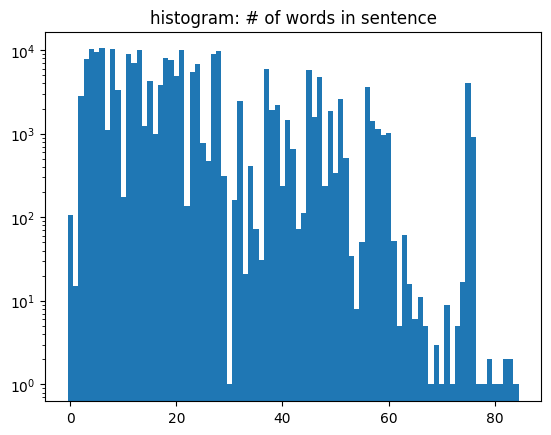

In [ ]:
from collections import Counter
c = Counter((len(t.split()) for t in flores_data['text']))
labels, values = zip(*c.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.yscale('log')
plt.title('histogram: # of words in sentence')

In [ ]:
8973/997

9.0

In [ ]:
from collections import Counter
Counter([len(df) for _,df in flores_data.groupby('language')])
for name, df in flores_data.groupby('language'):
  if len(df) in set((1994, 8973, 2991, 5982)):
    print(name, len(df))

ace 1994
arb 1994
bjn 1994
kas 1994
knc 1994
min 1994
taq 1994
zho 1994


Text(0.5, 1.0, 'histogram: # of texts per language')

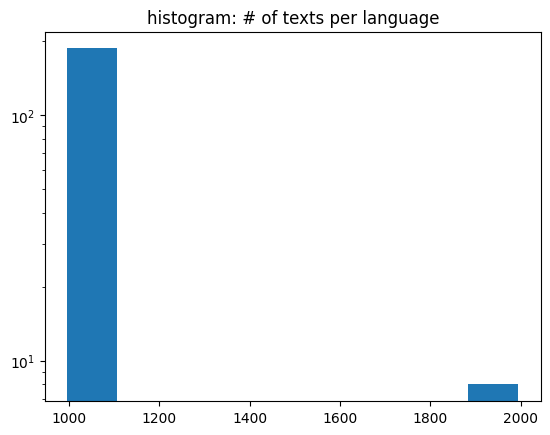

In [ ]:
plt.hist([len(df) for _,df in flores_data.groupby('language')], bins='auto')
plt.yscale('log')
plt.title('histogram: # of texts per language')

In [ ]:
uniq = np.unique(flores_data.language)
uniq, uniq.shape

(array(['ace', 'acm', 'acq', 'aeb', 'afr', 'aka', 'als', 'amh', 'apc',
        'arb', 'ars', 'ary', 'arz', 'asm', 'ast', 'awa', 'ayr', 'azb',
        'azj', 'bak', 'bam', 'ban', 'bel', 'bem', 'ben', 'bho', 'bjn',
        'bod', 'bos', 'bug', 'bul', 'cat', 'ceb', 'ces', 'cjk', 'ckb',
        'crh', 'cym', 'dan', 'deu', 'dik', 'dyu', 'dzo', 'ell', 'eng',
        'epo', 'est', 'eus', 'ewe', 'fao', 'fij', 'fin', 'fon', 'fra',
        'fur', 'fuv', 'gaz', 'gla', 'gle', 'glg', 'grn', 'guj', 'hat',
        'hau', 'heb', 'hin', 'hne', 'hrv', 'hun', 'hye', 'ibo', 'ilo',
        'ind', 'isl', 'ita', 'jav', 'jpn', 'kab', 'kac', 'kam', 'kan',
        'kas', 'kat', 'kaz', 'kbp', 'kea', 'khk', 'khm', 'kik', 'kin',
        'kir', 'kmb', 'kmr', 'knc', 'kon', 'kor', 'lao', 'lij', 'lim',
        'lin', 'lit', 'lmo', 'ltg', 'ltz', 'lua', 'lug', 'luo', 'lus',
        'lvs', 'mag', 'mai', 'mal', 'mar', 'min', 'mkd', 'mlt', 'mni',
        'mos', 'mri', 'mya', 'nld', 'nno', 'nob', 'npi', 'nso', 'nus',
      

In [ ]:
# function to clean text
def clean_txt(text):
    text=text.lower()
    text=re.sub(r'[^\w\s]',' ',text)
    text=re.sub(r'[_0-9]',' ',text)
    text=re.sub(r'\s\s+',' ',text)
    return text

# example
txt = 'my (&*(()))name %$#is harsh_priye'
print(clean_txt(txt))

my name is harsh priye


In [ ]:
# x_train = [clean_txt(text) for text in tqdm(x_train)]
# x_test = [clean_txt(text) for text in tqdm(x_test)]

## Final processing

## Add macro languages

In [ ]:
# add macro language
macros = [iso639.Language.from_part3(t).macrolanguage for t in flores_data['language']]
flores_data['language'] = [m if m is not None else l for m,l in zip(macros, flores_data['language'])]
# flores_data['is_macro'] = [True if m is not None else False for m in macros]


In [ ]:
# convert all the names to a more readable form
flores_data['language'] = [iso639.Language.from_part3(p).name for p in flores_data['language']]
# flores_data['macro'] = [iso639.Language.from_part3(p).name for p in flores_data['macro']]

In [ ]:
flores_data

,text,language
0,"Vào hôm thứ Hai, các nhà khoa học thuộc Trường...",Vietnamese
1,Các nhà nghiên cứu chính nói rằng điều này có ...,Vietnamese
2,Chiếc JAS 39C Gripen đâm xuống đường băng vào ...,Vietnamese
3,Viên phi công được xác định là Chỉ huy đội bay...,Vietnamese
4,Truyền thông địa phương đưa tin một phương tiệ...,Vietnamese
...,...,...
202386,تپه ایستگاه لارینین توریسم فصلی معمولا هندوستا...,Azerbaijani
202387,البته، اورالار قیش دا، بیر فرقلی گوزللیخ و جذب...,Azerbaijani
202388,آز اوچاق شرکت لری یاس مراسیمینه تخفیف پیشنهاد ...,Azerbaijani
202389,او اوچاق شرکت لری که بو تخفیفلری وریلر، ایر کا...,Azerbaijani


In [ ]:
uniq = np.unique(flores_data.language)
uniq, uniq.shape

(array(['Achinese', 'Afrikaans', 'Akan', 'Albanian', 'Amharic', 'Arabic',
        'Armenian', 'Assamese', 'Asturian', 'Awadhi', 'Aymara',
        'Azerbaijani', 'Balinese', 'Bambara', 'Bashkir', 'Basque',
        'Belarusian', 'Bemba (Zambia)', 'Bengali', 'Bhojpuri', 'Buginese',
        'Bulgarian', 'Burmese', 'Catalan', 'Cebuano',
        'Central Atlas Tamazight', 'Chhattisgarhi', 'Chinese', 'Chokwe',
        'Crimean Tatar', 'Czech', 'Danish', 'Dinka', 'Dutch', 'Dyula',
        'Dzongkha', 'English', 'Esperanto', 'Estonian', 'Ewe', 'Faroese',
        'Fijian', 'Finnish', 'Fon', 'French', 'Friulian', 'Fulah',
        'Galician', 'Ganda', 'Georgian', 'German', 'Guarani', 'Gujarati',
        'Haitian', 'Hausa', 'Hebrew', 'Hindi', 'Hungarian', 'Icelandic',
        'Igbo', 'Iloko', 'Irish', 'Italian', 'Japanese', 'Javanese',
        'Kabiyè', 'Kabuverdianu', 'Kabyle', 'Kachin', 'Kamba (Kenya)',
        'Kannada', 'Kanuri', 'Kashmiri', 'Kazakh', 'Khmer', 'Kikuyu',
        'Kimbundu', 'Kin

In [ ]:
language_families = {
    'Achinese': 'Austronesian',
    'Afrikaans': 'Indo-European',
    'Akan': 'Niger-Congo',
    'Albanian': 'Indo-European',
    'Amharic': 'Afroasiatic',
    'Arabic': 'Afroasiatic',
    'Armenian': 'Indo-European',
    'Assamese': 'Indo-European',
    'Asturian': 'Indo-European',
    'Awadhi': 'Indo-European',
    'Aymara': 'Aymaran',
    'Azerbaijani': 'Turkic',
    'Balinese': 'Austronesian',
    'Bambara': 'Niger-Congo',
    'Bashkir': 'Turkic',
    'Basque': 'Language Isolate',
    'Belarusian': 'Indo-European',
    'Bemba (Zambia)': 'Niger-Congo',
    'Bengali': 'Indo-European',
    'Bhojpuri': 'Indo-European',
    'Buginese': 'Austronesian',
    'Bulgarian': 'Indo-European',
    'Burmese': 'Sino-Tibetan',
    'Catalan': 'Indo-European',
    'Cebuano': 'Austronesian',
    'Central Atlas Tamazight': 'Afroasiatic',
    'Chhattisgarhi': 'Indo-European',
    'Chinese': 'Sino-Tibetan',
    'Chokwe': 'Niger-Congo',
    'Crimean Tatar': 'Turkic',
    'Czech': 'Indo-European',
    'Danish': 'Indo-European',
    'Dinka': 'Nilo-Saharan',
    'Dutch': 'Indo-European',
    'Dyula': 'Niger-Congo',
    'Dzongkha': 'Sino-Tibetan',
    'English': 'Indo-European',
    'Esperanto': 'Constructed',
    'Estonian': 'Uralic',
    'Ewe': 'Niger-Congo',
    'Faroese': 'Indo-European',
    'Fijian': 'Austronesian',
    'Finnish': 'Uralic',
    'Fon': 'Niger-Congo',
    'French': 'Indo-European',
    'Friulian': 'Indo-European',
    'Fulah': 'Niger-Congo',
    'Galician': 'Indo-European',
    'Ganda': 'Niger-Congo',
    'Georgian': 'Kartvelian',
    'German': 'Indo-European',
    'Guarani': 'Tupian',
    'Gujarati': 'Indo-European',
    'Haitian': 'Indo-European',
    'Hausa': 'Afroasiatic',
    'Hebrew': 'Afroasiatic',
    'Hindi': 'Indo-European',
    'Hungarian': 'Uralic',
    'Icelandic': 'Indo-European',
    'Igbo': 'Niger-Congo',
    'Iloko': 'Austronesian',
    'Irish': 'Indo-European',
    'Italian': 'Indo-European',
    'Japanese': 'Japonic',
    'Javanese': 'Austronesian',
    'Kabiyè': 'Niger-Congo',
    'Kabuverdianu': 'Indo-European',
    'Kabyle': 'Afroasiatic',
    'Kachin': 'Sino-Tibetan',
    'Kamba (Kenya)': 'Niger-Congo',
    'Kannada': 'Dravidian',
    'Kanuri': 'Afroasiatic',
    'Kashmiri': 'Indo-European',
    'Kazakh': 'Turkic',
    'Khmer': 'Austroasiatic',
    'Kikuyu': 'Niger-Congo',
    'Kimbundu': 'Niger-Congo',
    'Kinyarwanda': 'Niger-Congo',
    'Kirghiz': 'Turkic',
    'Kongo': 'Niger-Congo',
    'Korean': 'Koreanic',
    'Kurdish': 'Indo-European',
    'Lao': 'Tai-Kadai',
    'Latvian': 'Indo-European',
    'Ligurian': 'Indo-European',
    'Limburgan': 'Indo-European',
    'Lingala': 'Niger-Congo',
    'Lithuanian': 'Indo-European',
    'Lombard': 'Indo-European',
    'Luba-Lulua': 'Niger-Congo',
    'Luo (Kenya and Tanzania)': 'Nilo-Saharan',
    'Lushai': 'Sino-Tibetan',
    'Luxembourgish': 'Indo-European',
    'Macedonian': 'Indo-European',
    'Magahi': 'Indo-European',
    'Maithili': 'Indo-European',
    'Malagasy': 'Austronesian',
    'Malay (macrolanguage)': 'Austronesian',
    'Malayalam': 'Dravidian',
    'Maltese': 'Afroasiatic',
    'Manipuri': 'Sino-Tibetan',
    'Maori': 'Austronesian',
    'Marathi': 'Indo-European',
    'Modern Greek (1453-)': 'Indo-European',
    'Mongolian': 'Mongolic',
    'Mossi': 'Niger-Congo',
    'Nepali (macrolanguage)': 'Indo-European',
    'Norwegian': 'Indo-European',
    'Nuer': 'Nilo-Saharan',
    'Nyanja': 'Niger-Congo',
    'Occitan (post 1500)': 'Indo-European',
    'Oriya (macrolanguage)': 'Indo-European',
    'Oromo': 'Afroasiatic',
    'Pangasinan': 'Austronesian',
    'Panjabi': 'Indo-European',
    'Papiamento': 'Creole',
    'Pedi': 'Niger-Congo',
    'Persian': 'Indo-European',
    'Polish': 'Indo-European',
    'Portuguese': 'Indo-European',
    'Pushto': 'Indo-European',
    'Quechua': 'Quechuan',
    'Romanian': 'Indo-European',
    'Rundi': 'Niger-Congo',
    'Russian': 'Indo-European',
    'Samoan': 'Austronesian',
    'Sango': 'Afroasiatic',
    'Sanskrit': 'Indo-European',
    'Santali': 'Austroasiatic',
    'Sardinian': 'Indo-European',
    'Scottish Gaelic': 'Indo-European',
    'Serbo-Croatian': 'Indo-European',
    'Shan': 'Tai-Kadai',
    'Shona': 'Niger-Congo',
    'Sicilian': 'Indo-European',
    'Silesian': 'Indo-European',
    'Sindhi': 'Indo-European',
    'Sinhala': 'Indo-European',
    'Slovak': 'Indo-European',
    'Slovenian': 'Indo-European',
    'Somali': 'Afroasiatic',
    'Southern Sotho': 'Niger-Congo',
    'Spanish': 'Indo-European',
    'Sundanese': 'Austronesian',
    'Swahili (macrolanguage)': 'Niger-Congo',
    'Swati': 'Niger-Congo',
    'Swedish': 'Indo-European',
    'Tagalog': 'Austronesian',
    'Tajik': 'Indo-European',
    'Tamashek': 'Afroasiatic',
    'Tamil': 'Dravidian',
    'Tatar': 'Turkic',
    'Telugu': 'Dravidian',
    'Thai': 'Tai-Kadai',
    'Tibetan': 'Sino-Tibetan',
    'Tigrinya': 'Afroasiatic',
    'Tok Pisin': 'Creole',
    'Tsonga': 'Niger-Congo',
    'Tswana': 'Niger-Congo',
    'Tumbuka': 'Niger-Congo',
    'Turkish': 'Turkic',
    'Turkmen': 'Turkic',
    'Uighur': 'Turkic',
    'Ukrainian': 'Indo-European',
    'Umbundu': 'Niger-Congo',
    'Urdu': 'Indo-European',
    'Uzbek': 'Turkic',
    'Venetian': 'Indo-European',
    'Vietnamese': 'Austroasiatic',
    'Waray (Philippines)': 'Austronesian',
    'Welsh': 'Indo-European',
    'Wolof': 'Niger-Congo',
    'Xhosa': 'Niger-Congo',
    'Yiddish': 'Indo-European',
    'Yoruba': 'Niger-Congo',
    'Zulu': 'Niger-Congo'
}


In [ ]:
for name, df in flores_data.groupby('language'):
  if not name in language_families:
    print(name)

In [ ]:
flores_data['macro'] = [language_families[n] for n in flores_data['language']]

In [ ]:
np.unique(flores_data.macro)

array(['Afroasiatic', 'Austroasiatic', 'Austronesian', 'Aymaran',
       'Constructed', 'Creole', 'Dravidian', 'Indo-European', 'Japonic',
       'Kartvelian', 'Koreanic', 'Language Isolate', 'Mongolic',
       'Niger-Congo', 'Nilo-Saharan', 'Quechuan', 'Sino-Tibetan',
       'Tai-Kadai', 'Tupian', 'Turkic', 'Uralic'], dtype=object)

## Enlarging Flores

In [ ]:
flores_data.head()

,text,language,macro
0,"Vào hôm thứ Hai, các nhà khoa học thuộc Trường...",Vietnamese,Austroasiatic
1,Các nhà nghiên cứu chính nói rằng điều này có ...,Vietnamese,Austroasiatic
2,Chiếc JAS 39C Gripen đâm xuống đường băng vào ...,Vietnamese,Austroasiatic
3,Viên phi công được xác định là Chỉ huy đội bay...,Vietnamese,Austroasiatic
4,Truyền thông địa phương đưa tin một phương tiệ...,Vietnamese,Austroasiatic


In [ ]:
# Assuming data_455 is already loaded as a DataFrame
unique_languages_data_455 = data_455['language'].unique()

# Assuming flores_data is already loaded as a DataFrame
unique_languages_flores_data = flores_data['language'].unique()

# Find languages in data_455 but not in flores_data
missing_languages = set(unique_languages_data_455) - set(unique_languages_flores_data)

# List the missing languages
print("Languages in data_455 but not in flores_data:")
for language in missing_languages:
    print(language)

Languages in data_455 but not in flores_data:
Tahitian
Xiang Chinese
Yakut
Tuvinian
Tonga (Tonga Islands)
Banjar
Moksha
Gilbertese
Pampanga
Baluchi
Kotava
Tetum
Võro
Tonga (Zambia)
Tahaggart Tamahaq
Northeastern Thai
Eastern Mari
Jinyu Chinese
Chinook jargon
Phoenician
Picard
Upper Sorbian
Khakas
Hawaiian
Aragonese
Jewish Palestinian Aramaic
Erromintxela
Tigre
Algerian Arabic
Rendille
Kashubian
Mi'kmaq
Emilian
Cornish
Kumyk
Levantine Arabic
Iranian Persian
Choctaw
Old Spanish
North Azerbaijani
Toki Pona
Libyan Arabic
Talysh
Navajo
Central Mnong
Jamaican Creole English
Literary Chinese
Fiji Hindi
Pattani Malay
North Moluccan Malay
Niuean
Ga
South Azerbaijani
Karachay-Balkar
Hakka Chinese
Láadan
Croatian
Bislama
Liv
Brithenig
K'iche'
Shuswap
Southern Kurdish
Swabian
Erzya
Standard Arabic
Avaric
Dhivehi
Tokelau
Ho
Karakhanid
Zeeuws
Creek
Interlingua (International Auxiliary Language Association)
Khasi
Mikasuki
Northern Haida
Western Mari
Central Huasteca Nahuatl
Interglossa
Bavarian
Plain

In [ ]:
# Group flores_data by 'language' and take the first 500 texts for each language
flores_data_cut = flores_data.groupby('language').head(500)

# Reset the index of the resulting DataFrame
flores_data_cut.reset_index(drop=True, inplace=True)

# Print the first few rows of the cut dataset to verify
print(flores_data_cut.head())

                                                text    language  \
0  Vào hôm thứ Hai, các nhà khoa học thuộc Trường...  Vietnamese   
1  Các nhà nghiên cứu chính nói rằng điều này có ...  Vietnamese   
2  Chiếc JAS 39C Gripen đâm xuống đường băng vào ...  Vietnamese   
3  Viên phi công được xác định là Chỉ huy đội bay...  Vietnamese   
4  Truyền thông địa phương đưa tin một phương tiệ...  Vietnamese   

           macro  
0  Austroasiatic  
1  Austroasiatic  
2  Austroasiatic  
3  Austroasiatic  
4  Austroasiatic  


In [ ]:
# Step 1: Filter data_455 to include only languages with 500 texts
languages_with_500_texts = data_455['language'].value_counts()
languages_with_500_texts = languages_with_500_texts[languages_with_500_texts >= 100]
filtered_data_455 = data_455[data_455['language'].isin(languages_with_500_texts.index)]

# Step 2: Append the filtered_data_455 to flores_data
combined_data = pd.concat([flores_data_cut, filtered_data_455], ignore_index=True)

# Verify the number of languages and texts
print("Number of unique languages in flores_data:", combined_data['language'].nunique())
print("Total number of texts in flores_data:", len(combined_data))


Number of unique languages in flores_data: 320
Total number of texts in flores_data: 11206399


In [ ]:
# Step 1: Filter data_455 to include only languages with 500 texts
languages_with_500_texts = data_455['language'].value_counts()
languages_with_500_texts = languages_with_500_texts[languages_with_500_texts >= 100]
filtered_data_455 = data_455[data_455['language'].isin(languages_with_500_texts.index)]

# Step 2: Create a DataFrame to hold the final combined data
combined_data = pd.DataFrame(columns=['text', 'language'])

# Step 3: Iterate through unique languages and add up to 500 texts for each
max_texts_per_language = 500
for language in languages_with_500_texts.index:
    language_data = filtered_data_455[filtered_data_455['language'] == language]

    # Limit the number of texts to a maximum of 500 per language
    if len(language_data) > max_texts_per_language:
        language_data = language_data.sample(n=max_texts_per_language, random_state=42)

    combined_data = combined_data.append(language_data, ignore_index=True)

# Verify the number of languages and texts
print("Number of unique languages in combined_data:", combined_data['language'].nunique())
print("Total number of texts in combined_data:", len(combined_data))


Number of unique languages in combined_data: 306
Total number of texts in combined_data: 141909


basically here is portrayed already the second stage of finetuning

In [ ]:
combined_data.to_feather('/content/drive/MyDrive/combined_data.feather')

## Finetuning on more languages using our pretrained model

In [5]:
combined_data = pd.read_feather('/content/drive/MyDrive/combined_data.feather')
combined_data.columns = ('text','language')
combined_data.head()

,text,language
0,save energy be positive,English
1,where did he learn to cook like this,English
2,there is a sunflower field near the train stat...,English
3,i ve never trusted tom and mary don t think i ...,English
4,he broke the glass,English


In [ ]:
unique_languages_combined_data= combined_data['language'].unique()

In [ ]:
len(unique_languages_combined_data)

306

In [ ]:
model = torch.load('/content/drive/MyDrive/finetuned_bert.pth')

In [ ]:
# Define the number of classes in your new dataset
num_classes = len(set(combined_data['language']))

# Modify the classification layer to match the number of classes
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(combined_data.text.values, combined_data.language.values, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((113527,), (113527,), (28382,), (28382,))

In [ ]:
model.classifier

Linear(in_features=768, out_features=306, bias=True)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

x_train_tokens = tokenizer(list(x_train), padding=True, truncation=True, return_tensors='pt', max_length=128)
x_test_tokens = tokenizer(list(x_test), padding=True, truncation=True, return_tensors='pt', max_length=128)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(x_train_tokens['input_ids'], x_train_tokens['attention_mask'], y_train_tensor)
test_dataset = TensorDataset(x_test_tokens['input_ids'], x_test_tokens['attention_mask'], y_test_tensor)

In [ ]:
# DataLoader setup
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f}")

Epoch 1/2 - Loss: 1.6808
Epoch 2/2 - Loss: 0.5727


AttributeError: ignored

In [ ]:
# Evaluation
model.eval()
all_preds = []
correct = 0
total = 0

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)[0]
        logits = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy*100:.2f}%")

Validation Accuracy: 84.48%


In [ ]:
torch.save(model, '/content/drive/MyDrive/finetuned_306_v1_bert.pth')

In [ ]:
# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f}")

Epoch 1/1 - Loss: 0.3927


In [ ]:
# Evaluation
model.eval()
all_preds = []
correct = 0
total = 0

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)[0]
        logits = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy*100:.2f}%")

Validation Accuracy: 85.93%


In [ ]:
torch.save(model, '/content/drive/MyDrive/finetuned_306_v2_bert.pth')

In [ ]:
y_pred = label_encoder.inverse_transform(all_preds)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_rep)

Accuracy: 0.8593
                                                            precision    recall  f1-score   support

                                                  Achinese       0.90      1.00      0.95        95
                                                 Afrikaans       0.89      0.87      0.88        95
                                              Ainu (Japan)       0.93      0.83      0.87        63
                                                      Akan       0.92      0.65      0.76       105
                                                  Albanian       0.82      0.90      0.86        90
                                           Algerian Arabic       0.88      0.73      0.80       104
                                                   Amharic       0.15      0.14      0.15        91
                                   Ancient Greek (to 1453)       1.00      0.96      0.98        96
                                            Ancient Hebrew       0.93      0.57   

In [ ]:
# Training loop
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f}")

# Evaluation
model.eval()
all_preds = []
correct = 0
total = 0

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)[0]
        logits = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy*100:.2f}%")

Epoch 1/2 - Loss: 0.3040
Epoch 2/2 - Loss: 0.2498
Validation Accuracy: 86.28%


In [ ]:
# Function to predict the language of a sentence
def predict_language(sentence, model, label_encoder, device):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=128)
    # Ensure the model is in evaluation mode
    model.eval()
    # Move input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}
    # Make predictions
    with torch.no_grad():
        logits = model(**inputs).logits
    # Get the predicted class
    predicted_class = torch.argmax(logits, dim=1).item()
    # Inverse transform the predicted class to the original language label
    predicted_language = label_encoder.inverse_transform([predicted_class])[0]
    return predicted_language

# Example usage
sentence1 = "This is a sample text."
sentence2 = 'मेरा नाम हर्ष हे'
sentence3 = 'すみません、その駅まで案内していただけますか'

# Ensure the model and input tensors are on the same device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predicted_language = predict_language(sentence1, model, label_encoder, device)
print(f"Predicted Language: {predicted_language}")
predicted_language = predict_language(sentence2, model, label_encoder, device)
print(f"Predicted Language: {predicted_language}")
predicted_language = predict_language(sentence3, model, label_encoder, device)
print(f"Predicted Language: {predicted_language}")

Predicted Language: English
Predicted Language: Nepali (individual language)
Predicted Language: Japanese


In [ ]:
torch.save(model, '/content/drive/MyDrive/finetuned_306_v3_bert.pth')

In [6]:
model = torch.load('/content/drive/MyDrive/finetuned_306_v3_bert.pth')

In [ ]:
# DataLoader setup
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training loop
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f}")

# Evaluation
model.eval()
all_preds = []
correct = 0
total = 0

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)[0]
        logits = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# Macro algorithm (not used)

In [ ]:
flores_data

,text,language,macro
0,"Vào hôm thứ Hai, các nhà khoa học thuộc Trường...",Vietnamese,Austroasiatic
1,Các nhà nghiên cứu chính nói rằng điều này có ...,Vietnamese,Austroasiatic
2,Chiếc JAS 39C Gripen đâm xuống đường băng vào ...,Vietnamese,Austroasiatic
3,Viên phi công được xác định là Chỉ huy đội bay...,Vietnamese,Austroasiatic
4,Truyền thông địa phương đưa tin một phương tiệ...,Vietnamese,Austroasiatic
...,...,...,...
202386,避暑地の観光シーズンは、一般的にインドの夏季にピークを迎えます。,Japanese,Japonic
202387,しかし、多くのヒルステーションには十分な積雪があり、スキーやスノーボードなどのアクティビティ...,Japanese,Japonic
202388,死別運賃をまだ提供している航空会社は数社のみですが、この運賃で葬儀直前の旅費がわずかに割り引...,Japanese,Japonic
202389,該当する航空会社は、エア・カナダ、デルタ航空、ルフトハンザ、ウェストジェットなどです。,Japanese,Japonic


In [ ]:
np.unique(list(flores_data.macro.values))

array(['Afroasiatic', 'Austroasiatic', 'Austronesian', 'Aymaran',
       'Constructed', 'Creole', 'Dravidian', 'Indo-European', 'Japonic',
       'Kartvelian', 'Koreanic', 'Language Isolate', 'Mongolic',
       'Niger-Congo', 'Nilo-Saharan', 'Quechuan', 'Sino-Tibetan',
       'Tai-Kadai', 'Tupian', 'Turkic', 'Uralic'], dtype='<U16')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Load your dataset (replace with your actual dataset)
# flores_data = pd.read_csv('your_dataset.csv')

# Split the dataset into train and test sets
x_train, x_test, y_train_macro, y_test_macro, y_train_language, y_test_language = train_test_split(
    flores_data.text.values, flores_data.macro.values, flores_data.language.values, test_size=0.2, random_state=42
)

# Function to clean text
def clean_txt(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[_0-9]', ' ', text)
    text = re.sub(r'\s\s+', ' ', text)
    return text

x_train = [clean_txt(text) for text in x_train]
x_test = [clean_txt(text) for text in x_test]

# Using Tfidf Vectorizer
tfidf = TfidfVectorizer()
tfidf.fit(x_train)
x_train_ready = tfidf.transform(x_train)
x_test_ready = tfidf.transform(x_test)

# Encode 'macro' labels using LabelEncoder
enc_macro = LabelEncoder()
enc_macro.fit(y_train_macro)
y_train_ready_macro = enc_macro.transform(y_train_macro)
y_test_ready_macro = enc_macro.transform(y_test_macro)

# Initialize the Naive Bayes model for 'macro' classification
nb_macro = MultinomialNB(fit_prior=False)
nb_macro.fit(x_train_ready, y_train_ready_macro)

# Make predictions for 'macro' classes
y_pred_macro = nb_macro.predict(x_test_ready)

# Reverse transform the encoded 'macro' predictions to original labels
y_pred_original_macro = enc_macro.inverse_transform(y_pred_macro)

# Initialize the Naive Bayes model for 'language' classification
nb_language = MultinomialNB(fit_prior=False)

# Create lists to store 'language' training and testing data based on 'macro' predictions
x_train_language = []
x_test_language = []
y_train_ready_language = []
y_test_ready_language = []

# Define language groups
language_groups = ['Afroasiatic', 'Austroasiatic', 'Austronesian', 'Aymaran',
       'Constructed', 'Creole', 'Dravidian', 'Indo-European', 'Japonic',
       'Kartvelian', 'Koreanic', 'Language Isolate', 'Mongolic',
       'Niger-Congo', 'Nilo-Saharan', 'Quechuan', 'Sino-Tibetan',
       'Tai-Kadai', 'Tupian', 'Turkic', 'Uralic']

# Filter 'language' data based on 'macro' predictions for each group
for i, predicted_macro_class in enumerate(y_pred_original_macro):
    if predicted_macro_class in language_groups:
        x_train_language.append(x_train[i])
        x_test_language.append(x_test[i])
        y_train_ready_language.append(y_train_language[i])
        y_test_ready_language.append(y_test_language[i])

# Remove empty or very sparse documents from 'language' data
x_train_language_clean = []
x_test_language_clean = []

for doc in x_train_language:
    if doc.strip():  # Check if the document is not empty
        x_train_language_clean.append(doc)

for doc in x_test_language:
    if doc.strip():  # Check if the document is not empty
        x_test_language_clean.append(doc)

# Using Tfidf Vectorizer for 'language' data
tfidf_language = TfidfVectorizer()
tfidf_language.fit(x_train_language_clean)  # Use the cleaned data
x_train_ready_language = tfidf_language.transform(x_train_language_clean)
x_test_ready_language = tfidf_language.transform(x_test_language_clean)

# Encode 'language' labels using LabelEncoder
enc_language = LabelEncoder()
enc_language.fit(y_train_ready_language)
y_train_ready_language_encoded = enc_language.transform(y_train_ready_language)
y_test_ready_language_encoded = enc_language.transform(y_test_ready_language)

# Train the Naive Bayes model for 'language' classification
nb_language.fit(x_train_ready_language, y_train_ready_language_encoded)

# Make predictions for 'language' classes
y_pred_language_encoded = nb_language.predict(x_test_ready_language)

# Reverse transform the encoded 'language' predictions to original labels
y_pred_original_language = enc_language.inverse_transform(y_pred_language_encoded)

# Generate a classification report for 'language' predictions
classification_rep_language = classification_report(y_test_ready_language, y_pred_original_language)

print("Classification Report for Language Predictions:")
print(classification_rep_language)


Classification Report for Language Predictions:
                          precision    recall  f1-score   support

                Achinese       0.34      0.99      0.50       376
               Afrikaans       0.99      0.98      0.99       192
                    Akan       0.93      1.00      0.96       416
                Albanian       1.00      0.99      0.99       190
                 Amharic       1.00      0.99      0.99       192
                  Arabic       0.98      1.00      0.99      1858
                Armenian       1.00      1.00      1.00       196
                Assamese       1.00      0.99      0.99       206
                Asturian       1.00      0.87      0.93       207
                  Awadhi       0.80      0.57      0.66       218
                  Aymara       1.00      0.97      0.99       185
             Azerbaijani       0.98      0.89      0.93       400
                Balinese       0.99      0.94      0.97       200
                 Bambara   

In [ ]:
def predict_language(text):
    # Clean and transform the input text
    cleaned_text = clean_txt(text)
    vectorized_text = tfidf.transform([cleaned_text])

    # Predict 'macro' class
    macro_class = nb_macro.predict(vectorized_text)

    # If 'macro' class is identified and is within language groups, predict 'language' class
    if macro_class[0] in language_groups:
        language_class_encoded = nb_language.predict(vectorized_text)
        language_class = enc_language.inverse_transform(language_class_encoded)
        return language_class[0]
    else:
        return 'Unknown'  # If 'macro' class is not identified or not within language groups

# Test the predict_language function with some sample sentences
sentence1 = "Hello, how are you today?"
sentence2 = "Bonjour, comment ça va aujourd'hui?"
sentence3 = "Привет, как вы сегодня?"
sentence4 = "Hola, ¿cómo estás hoy?"
sentence5 = "नमस्ते, आज आप कैसे हैं?"

print(predict_language(sentence1))
print(predict_language(sentence2))
print(predict_language(sentence3))
print(predict_language(sentence4))
print(predict_language(sentence5))


Unknown
Unknown
Unknown
Unknown
Unknown


In [ ]:
sentence1 = "Hello, how are you today?"
cleaned_text = clean_txt(sentence1)
vectorized_text = tfidf.transform([cleaned_text])
macro_class = nb_macro.predict(vectorized_text)


In [ ]:
macro_class

array([7])

In [ ]:
# use pipeline to combine prefitted vectorizer and trained model into one object
model = Pipeline([('vectorizer',tfidf),('nb',nb)])
# function to predict language from text
def predict(text):
    pred = model.predict([clean_txt(text)])
    ans = enc.inverse_transform(pred)
    return ans[0]

predict('my name is harsh'), predict('मेरा नाम हर्ष हे'), predict('mi nombre es harsh'), predict('меня зовут Харш'), predict('mon nom est harsh')

Unknown
Unknown
Unknown
Unknown
Unknown


In [ ]:
## Я охуела

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

class LanguagePredictor:
    def __init__(self, dataset_path):
        # Load your dataset (replace with your actual dataset path)
        self.data = data
        self.language_model = self.train_language_model()

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'[_0-9]', ' ', text)
        text = re.sub(r'\s\s+', ' ', text)
        return text

    def train_language_model(self):
        x_train, y_train_macro, y_train_language = self.data.text.values, self.data.macro.values, self.data.language.values
        x_train = [self.clean_text(text) for text in x_train]

        # Using Tfidf Vectorizer
        tfidf = TfidfVectorizer()
        tfidf.fit(x_train)
        x_train_ready = tfidf.transform(x_train)

        # Initialize the Naive Bayes model for 'macro' classification
        nb_macro = MultinomialNB(fit_prior=False)
        nb_macro.fit(x_train_ready, y_train_macro)

        # Initialize the Naive Bayes model for 'language' classification
        nb_language = MultinomialNB(fit_prior=False)

        # Train 'language' model based on 'macro' predictions
        language_groups = set(y_train_macro)
        x_train_language, y_train_ready_language = [], []

        for i, predicted_macro_class in enumerate(nb_macro.predict(x_train_ready)):
            if predicted_macro_class in language_groups:
                x_train_language.append(x_train[i])
                y_train_ready_language.append(y_train_language[i])

        x_train_language = [self.clean_text(text) for text in x_train_language]

        # Using Tfidf Vectorizer for 'language' data
        tfidf_language = TfidfVectorizer()
        tfidf_language.fit(x_train_language)
        x_train_ready_language = tfidf_language.transform(x_train_language)

        # Encode 'language' labels using LabelEncoder
        enc_language = LabelEncoder()
        enc_language.fit(y_train_ready_language)
        y_train_ready_language_encoded = enc_language.transform(y_train_ready_language)

        # Train the Naive Bayes model for 'language' classification
        nb_language.fit(x_train_ready_language, y_train_ready_language_encoded)

        return nb_macro, nb_language, tfidf, enc_language

    def predict_language(self, text):
        cleaned_text = self.clean_text(text)
        x_test_ready = self.language_model[2].transform([cleaned_text])

        # Predict 'macro' class
        macro_pred = self.language_model[0].predict(x_test_ready)[0]

        # If 'macro' prediction is not in language groups, return 'unknown'
        if macro_pred not in self.language_model[3].classes_:
            return 'unknown'

        # Predict 'language' class
        language_pred_encoded = self.language_model[1].predict(x_test_ready)
        language_pred_original = self.language_model[3].inverse_transform(language_pred_encoded)

        return language_pred_original[0], macro_pred


In [ ]:


# Predict language
text = 'my name is John'
language_prediction = predictor.predict_language(text)
print(language_prediction)

unknown


In [ ]:
# Create an instance of LanguagePredictor
predictor = LanguagePredictor(flores_data)
text = 'my name is John'
language_prediction, macro_pred = predictor.predict_language(text)
print(language_prediction, macro_pred)

ValueError: ignored